In [ ]:
import cv2
import os

video_path = "/content/Himanshu_New_Dataset.mp4"
output_dir = "dataset/raw_frames"
os.makedirs(output_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_filename = os.path.join(output_dir, f"frame_{frame_count:05d}.jpg")
    cv2.imwrite(frame_filename, frame)
    frame_count += 1

cap.release()
print(f"Extracted {frame_count} frames to {output_dir}")


Extracted 1153 frames to dataset/raw_frames


In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.12.0.88
    Uninstalling open

# Dataset Labelling

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

mp_face_mesh = mp.solutions.face_mesh


In [ ]:
def eye_aspect_ratio(landmarks, left_indices, right_indices):
    # EAR for one eye
    def single_eye(eye_indices):
        p1, p2, p3, p4, p5, p6 = [landmarks[i] for i in eye_indices]
        A = np.linalg.norm(p2 - p6)
        B = np.linalg.norm(p3 - p5)
        C = np.linalg.norm(p1 - p4)
        return (A + B) / (2.0 * C)

    leftEAR = single_eye(left_indices)
    rightEAR = single_eye(right_indices)
    return (leftEAR + rightEAR) / 2.0

def mouth_opening_ratio(landmarks, top, bottom, left, right):
    A = np.linalg.norm(landmarks[top] - landmarks[bottom])  # vertical opening
    C = np.linalg.norm(landmarks[left] - landmarks[right])  # horizontal width
    return A / C

def nose_length_ratio(landmarks, top, bottom, left, right):
    A = np.linalg.norm(landmarks[top] - landmarks[bottom])  # vertical length
    B = np.linalg.norm(landmarks[left] - landmarks[right])  # horizontal width
    return A / B


In [ ]:
# ---------------- Preprocessing -----------------
def features_to_image(ear, mor, nlr, size=224):
    ear_img = np.ones((size, size)) * ear
    mor_img = np.ones((size, size)) * mor
    nlr_img = np.ones((size, size)) * nlr
    feature_img = np.stack([ear_img, mor_img, nlr_img], axis=-1)
    feature_img = feature_img.astype("float32")
    return feature_img


In [ ]:
import os
video_path = "/content/Himanshu_New_Dataset.mp4"
output_base = "dataset"

for split in ["train", "val", "test"]:
    for label in ["drowsy", "alert"]:
        os.makedirs(os.path.join(output_base, split, label), exist_ok=True)


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os

# ---------------- Feature Functions ----------------
def eye_aspect_ratio(eye):
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    return (A + B) / (2.0 * C)

def mouth_opening_ratio(mouth_points):
    A = np.linalg.norm(mouth_points[0] - mouth_points[1])  # top-bottom
    C = np.linalg.norm(mouth_points[2] - mouth_points[3])  # left-right
    return A / C

def nose_length_ratio(nose_points):
    A = np.linalg.norm(nose_points[0] - nose_points[1])  # vertical
    B = np.linalg.norm(nose_points[2] - nose_points[3])  # horizontal
    return A / B

# ---------------- MediaPipe Setup ----------------
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)

cap = cv2.VideoCapture(video_path)
frame_count = 0

# Thresholds (tune as needed)
EAR_THRESHOLD = 0.25
MOR_THRESHOLD = 0.5
NLR_THRESHOLD = 0.9

# Landmark indices (MediaPipe FaceMesh)
LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]
MOUTH_TOP, MOUTH_BOTTOM, MOUTH_LEFT, MOUTH_RIGHT = 13, 14, 61, 291
NOSE_TOP, NOSE_BOTTOM, NOSE_LEFT, NOSE_RIGHT = 168, 2, 102, 331

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    label = "alert"
    if results.multi_face_landmarks:
        h, w, _ = frame.shape
        mesh_points = np.array([[int(p.x * w), int(p.y * h)] for p in results.multi_face_landmarks[0].landmark])

        # EAR
        leftEAR = eye_aspect_ratio(mesh_points[LEFT_EYE])
        rightEAR = eye_aspect_ratio(mesh_points[RIGHT_EYE])
        ear = (leftEAR + rightEAR) / 2.0

        # MOR
        mor = mouth_opening_ratio([mesh_points[MOUTH_TOP], mesh_points[MOUTH_BOTTOM],
                                   mesh_points[MOUTH_LEFT], mesh_points[MOUTH_RIGHT]])

        # NLR
        nlr = nose_length_ratio([mesh_points[NOSE_TOP], mesh_points[NOSE_BOTTOM],
                                 mesh_points[NOSE_LEFT], mesh_points[NOSE_RIGHT]])

        # Drowsiness condition (any feature below/above threshold)
        if ear < EAR_THRESHOLD or mor > MOR_THRESHOLD or nlr < NLR_THRESHOLD:
            label = "drowsy"

    # Train/val/test split
    split = "train"
    if frame_count % 10 == 0:
        split = "val"
    elif frame_count % 20 == 0:
        split = "test"

    save_path = os.path.join(output_base, split, label, f"frame_{frame_count:05d}.jpg")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    cv2.imwrite(save_path, frame)
    frame_count += 1

cap.release()
face_mesh.close()
print(f"Processed {frame_count} frames into dataset with auto-labeling (EAR, MOR, NLR + MediaPipe)")


Processed 1153 frames into dataset with auto-labeling (EAR, MOR, NLR + MediaPipe)


# Loading MobileNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# ---------------- Data pipeline ----------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data generators (rescaling + split)
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    "/content/dataset/train",   # contains /alert and /drowsy
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    "/content/dataset/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)

# ---------------- Model ----------------
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights="imagenet")
base_model.trainable = False  # freeze convolutional base

inputs = layers.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)

# ---------------- Compile ----------------
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()

# ---------------- Train ----------------
EPOCHS = 10  # change as needed
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


Found 830 images belonging to 2 classes.
Found 207 images belonging to 2 classes.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 552ms/step - accuracy: 0.8105 - loss: 0.4307 - val_accuracy: 0.9710 - val_loss: 0.1034
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.9692 - loss: 0.0683 - val_accuracy: 0.9372 - val_loss: 0.1606
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9707 - loss: 0.0703 - val_accuracy: 0.9710 - val_loss: 0.0940
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9833 - loss: 0.0468 - val_accuracy: 0.9517 - val_loss: 0.1214
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9731 - loss: 0.0535 - val_accuracy: 0.9710 - val_loss: 0.0988
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9838 - loss: 0.0555 - val_accuracy: 0.9710 - val_loss: 0.1015
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9753 - loss: 0.0593 - val_accuracy: 0.9517 - val_loss: 0.1270
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9722 - loss: 0.0596 - val_accuracy: 0.951

In [ ]:
# Save correctly
model.save("mobilenet_drowsy_all_05_sept_feature.h5")

# Graphs and Metrics

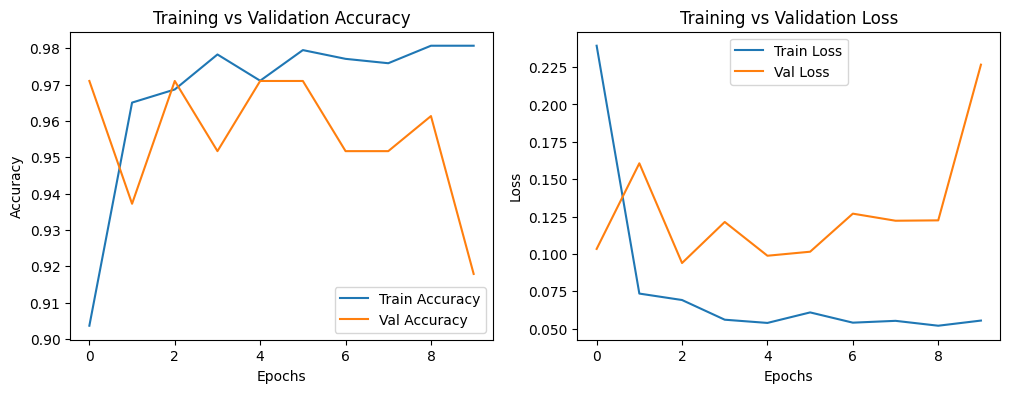

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()


Found 116 images belonging to 2 classes.
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step


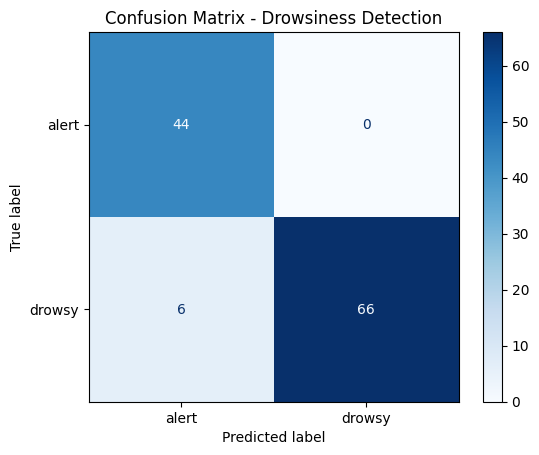

              precision    recall  f1-score   support

       alert       0.88      1.00      0.94        44
      drowsy       1.00      0.92      0.96        72

    accuracy                           0.95       116
   macro avg       0.94      0.96      0.95       116
weighted avg       0.95      0.95      0.95       116



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/content/dataset/val",
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode="binary",
    shuffle=False
)

# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Drowsiness Detection")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


# Last graph